In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import shap

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import xgboost as xgb

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

import optuna
import os
from scipy import stats

import joblib

In [2]:
train = pd.read_csv("../data/train.csv")
predict = pd.read_csv("../data/test.csv")

# データの前処理

## 特徴量の作成

In [3]:
mapping = {
    'foggy': 1,
    'clear': 2,
    'rainy': 3
}

In [4]:
def create_features(df):
    # カーブと報告事故件数
    df['curavture_accidents'] = df['curvature'] * df['num_reported_accidents']
    #df['time_school_accidents'] = df['time_of_day'] +'_'+ df['num_reported_accidents'].astype(str)
    #df['weather_accidents'] = df['weather'] +'_'+ df['num_reported_accidents'].astype(str)
    #df['speed_accidents'] = df['speed_limit'] * df['num_reported_accidents']
    #df['cuavature_speed'] = df['curvature'] * df['speed_limit']

    #df['cuvature_weather'] = df['curvature'] * df['weather'].map(mapping)

    df['high_risk_codition'] = df['speed_limit'] >= 60 & (df['weather'] != 'clear')

    # --- BINARY列の作成 --- 数字の順序は意味のない，4つのbool型をまとめた特徴量の作成
    BINARY_COLS = ['road_signs_present', 'public_road', 'holiday', 'school_season']
    df['BINARY'] = 0
    for i in range(len(BINARY_COLS)):
        df['BINARY'] += df[BINARY_COLS[i]].astype(int) * (2 ** i)



    df['base_risk'] = (
        0.3 * df["curvature"] + 
        0.2 * (df["lighting"] == "night").astype(int) + 
        0.1 * (df["weather"] != "clear").astype(int) + 
        0.2 * (df["speed_limit"] >= 60).astype(int) + 
        0.1 * (np.array(df["num_reported_accidents"]) > 2).astype(int)
    )

    return df

train = create_features(train)
predict = create_features(predict)

## object型のラベル付け

In [5]:
# One-Hot Encoding
def one_hot_encode(df, columns):
    df = pd.get_dummies(df, columns=columns, drop_first=False)
    return df

encode_columns = ['road_type', 'lighting', 'weather', 'time_of_day']

# trainとpredictで同じダミー列に揃えるための処理
train = one_hot_encode(train, encode_columns)
predict = one_hot_encode(predict, encode_columns)

# 列がずれないように、trainにあってpredictにない列を補う
missing_cols = set(train.columns) - set(predict.columns)
for col in missing_cols:
    predict[col] = 0

# 列の順番をtrainと合わせる
predict = predict[train.columns]
predict = predict.drop(columns=['accident_risk'])

In [6]:
# bool型の変換

def bool_to_int(df):
    bool_columns = df.select_dtypes(include='bool').columns
    for col in bool_columns:
        df[col] = df[col].astype(int)
    return df

train = bool_to_int(train)
predict = bool_to_int(predict)

## スケーリング

In [7]:
# 残留誤差が大きいため，異常値に強いRobustScalerを使用
def robust_scale(df):
    scaler = RobustScaler()

    numeric_columns = ['curvature','curavture_accidents']

    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])
    return df

train = robust_scale(train)
predict = robust_scale(predict)

## データの分割

In [8]:
def split_data(df,test_size=0.2,random_state=42):
    X = df.drop(columns=['id','accident_risk'])
    y = df['accident_risk']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(train)

predict_X = predict.copy()
predict_X = predict_X.drop(columns=['id'])

# モデルの学習

In [9]:
import lightgbm as lgb

# LightGBMモデルの構築
def build_lightgbm_model(n_estimators=100, max_depth=5, learning_rate=0.1):
    """LightGBMモデルを構築する関数（回帰）"""
    model = lgb.LGBMRegressor(
        objective='regression',  # 回帰タスク用
        n_estimators=n_estimators,  # 決定木の数
        max_depth=max_depth,  # 木の深さ
        learning_rate=learning_rate,  # 学習率
        random_state=42  # 再現性のためのシード
    )
    return model

# モデルの構築
lgb_model = build_lightgbm_model()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 414203, number of used features: 23
[LightGBM] [Info] Start training from score 0.352605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

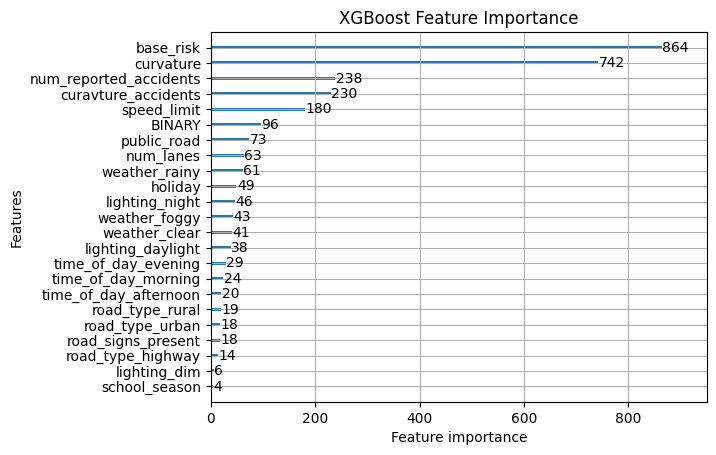

In [10]:
import matplotlib.pyplot as plt

# Train XGBoost model
lgb_model.fit(X_train, y_train) # XGBoostモデルの学習

# Feature importance
lgb.plot_importance(lgb_model) # 特徴量の重要度をプロット
plt.title('XGBoost Feature Importance') # タイトル
plt.show() # グラフの表示

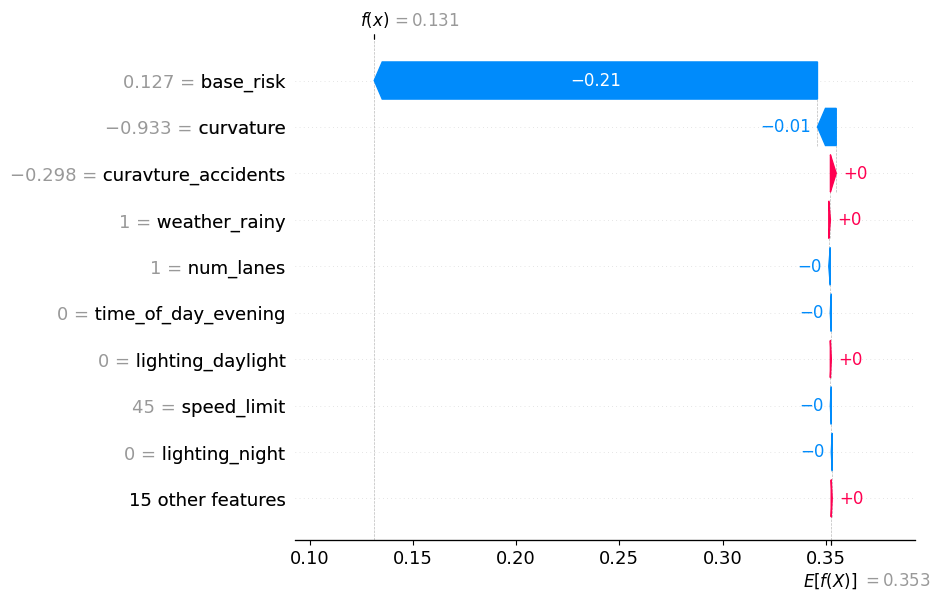

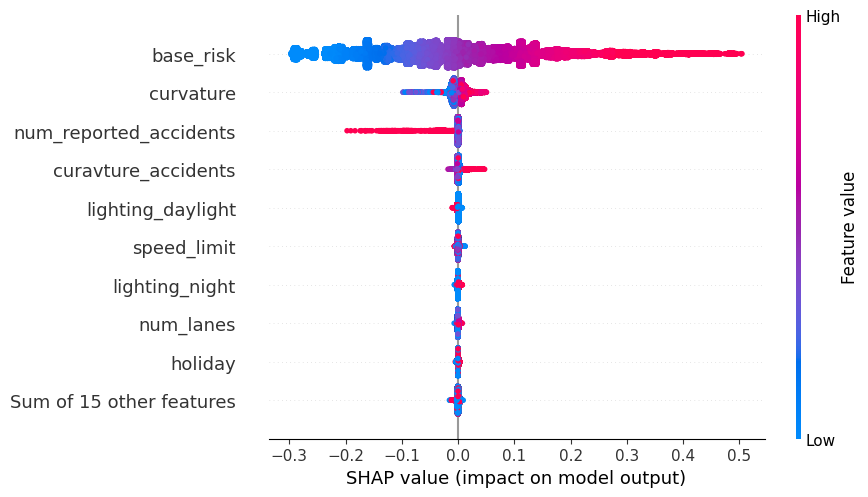

In [11]:
def explain_model(model):
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    
    shap.plots.waterfall(shap_values[0])

    shap.plots.beeswarm(shap_values)

explain_model(lgb_model)

# モデルの評価

In [12]:
# テストデータの予測
lgb_pred = lgb_model.predict(X_test)

In [13]:
def evaluate_metrics(y_true,y_pred):
    results = []

    def calulate_metrics(y_true,y_pred):
        mse = mean_squared_error(y_true,y_pred)
        mae = mean_absolute_error(y_true,y_pred)
        r2 = r2_score(y_true,y_pred)
        return {
            'MSE':mse,
            'MAE':mae,
            'R2':r2
        }

    results.append(calulate_metrics(y_true,y_pred))
    
    return pd.DataFrame(results)

# 評価指標の計算
results = evaluate_metrics(y_test,lgb_pred)
display(results)

,MSE,MAE,R2
0,0.003182,0.043781,0.884756


# Optuna

In [14]:
#"""
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Optunaで最適化する関数
def optimize_lightgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500), # 決定木の数
        'max_depth': trial.suggest_int('max_depth', 3, 10), # 決定木の深さ
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3), # 学習率
        'subsample': trial.suggest_float('subsample', 0.6, 1.0), # サブサンプル
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0), # 列のサブサンプル
        'num_leaves': trial.suggest_int('num_leaves', 31, 128), # 最大葉の数
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100), # 葉ノードが持つ最小サンプル数
        'objective': 'regression', # 回帰タスクに適した損失関
        'verbose': -1 , # InfoやWarningを非表示にする
        'random_state': 42
    }

    # LightGBMモデルの学習
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)

    # 予測と評価
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

# Optunaによる最適化
study = optuna.create_study(direction='minimize')
#optuna.logging.set_verbosity(optuna.logging.INFO)
study.optimize(optimize_lightgbm, n_trials=100)

# 最良のトライアル結果を表示
print('Best trial:')
trial = study.best_trial  # 最良のトライアル
print(f"  MSE: {trial.value}")
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# 最良のパラメータでモデルを最適化
optimized_lgb = lgb.LGBMRegressor(**trial.params, random_state=42)
optimized_lgb.fit(X_train, y_train)
#"""

[I 2025-10-19 14:06:33,192] A new study created in memory with name: no-name-10a84f01-cda8-45bd-8456-29a10cc81d17
[I 2025-10-19 14:06:34,215] Trial 0 finished with value: 0.0031613861274723863 and parameters: {'n_estimators': 127, 'max_depth': 9, 'learning_rate': 0.20810663013630262, 'subsample': 0.949329620497529, 'colsample_bytree': 0.8981425319206202, 'num_leaves': 36, 'min_child_samples': 28}. Best is trial 0 with value: 0.0031613861274723863.
[I 2025-10-19 14:06:38,040] Trial 1 finished with value: 0.003169879229233681 and parameters: {'n_estimators': 386, 'max_depth': 6, 'learning_rate': 0.025552899325556044, 'subsample': 0.8819499574643999, 'colsample_bytree': 0.8716252782601488, 'num_leaves': 80, 'min_child_samples': 52}. Best is trial 0 with value: 0.0031613861274723863.
[I 2025-10-19 14:06:38,464] Trial 2 finished with value: 0.0031830477566264287 and parameters: {'n_estimators': 56, 'max_depth': 5, 'learning_rate': 0.22099956777224053, 'subsample': 0.9181766268599004, 'colsa

Best trial:
  MSE: 0.0031552610495742765
  Params: 
    n_estimators: 482
    max_depth: 6
    learning_rate: 0.07248315676243042
    subsample: 0.9532238600668884
    colsample_bytree: 0.8492417956319313
    num_leaves: 113
    min_child_samples: 87


LGBMRegressor(colsample_bytree=0.8492417956319313,
              learning_rate=0.07248315676243042, max_depth=6,
              min_child_samples=87, n_estimators=482, num_leaves=113,
              random_state=42, subsample=0.9532238600668884)

In [15]:
optimized_pred = optimized_lgb.predict(X_test)
optimized_metrics = evaluate_metrics(y_test,  optimized_pred) # 評価
display(optimized_metrics)

,MSE,MAE,R2
0,0.003155,0.043571,0.885729


In [16]:
def plot_residual_analysis(y_test, optimized_pred, figsize=(16, 12)):

    residuals = y_test - optimized_pred
    
    # 統計量の計算
    rmse = np.sqrt(np.mean(residuals**2))
    mae = np.mean(np.abs(residuals))
    r2 = 1 - (np.sum(residuals**2) / np.sum((y_test - np.mean(y_test))**2))
    
    # 2x2のサブプロット作成
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # ========================================
    # 1. 実際値 vs 予測値（左上）
    # ========================================
    ax1 = axes[0, 0]
    ax1.scatter(y_test, optimized_pred, alpha=0.5, s=30, edgecolors='k', linewidths=0.5)
    
    # 完全予測ライン（y=x）
    min_val = min(y_test.min(), optimized_pred.min())
    max_val = max(y_test.max(), optimized_pred.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    ax1.set_xlabel('Actual Accident Risk', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Predicted Accident Risk', fontsize=12, fontweight='bold')
    ax1.set_title('Actual vs Predicted Values', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 統計情報をテキストで表示
    textstr = f'RMSE: {rmse:.5f}\nMAE: {mae:.5f}\nR²: {r2:.5f}'
    ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # ========================================
    # 2. 残差プロット（右上）
    # ========================================
    ax2 = axes[0, 1]
    ax2.scatter(optimized_pred, residuals, alpha=0.5, s=30, edgecolors='k', linewidths=0.5)
    ax2.axhline(y=0, color='r', linestyle='--', lw=2, label='Zero Residual')
    
    ax2.set_xlabel('Predicted Accident Risk', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Residuals (Actual - Predicted)', fontsize=12, fontweight='bold')
    ax2.set_title('Residual Plot', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 残差の範囲を表示
    std_residual = np.std(residuals)
    ax2.axhline(y=2*std_residual, color='orange', linestyle=':', alpha=0.7, label='±2σ')
    ax2.axhline(y=-2*std_residual, color='orange', linestyle=':', alpha=0.7)
    
    # ========================================
    # 3. 残差のヒストグラム（左下）
    # ========================================
    ax3 = axes[1, 0]
    ax3.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    ax3.axvline(x=0, color='r', linestyle='--', lw=2, label='Zero')
    ax3.axvline(x=np.mean(residuals), color='green', linestyle='-', lw=2, 
                label=f'Mean: {np.mean(residuals):.5f}')
    
    ax3.set_xlabel('Residuals', fontsize=12, fontweight='bold')
    ax3.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax3.set_title('Distribution of Residuals', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # ========================================
    # 4. Q-Qプロット（右下）
    # ========================================
    ax4 = axes[1, 1]
    stats.probplot(residuals, dist="norm", plot=ax4)
    ax4.set_title('Q-Q Plot (Normality Check)', fontsize=14, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ========================================
    # 統計サマリーを出力
    # ========================================
    print("=" * 60)
    print("残差分析サマリー")
    print("=" * 60)
    print(f"サンプル数: {len(y_test)}")
    print(f"\n【評価指標】")
    print(f"RMSE (Root Mean Squared Error): {rmse:.6f}")
    print(f"MAE  (Mean Absolute Error):     {mae:.6f}")
    print(f"R²   (Coefficient of Determination): {r2:.6f}")
    print(f"\n【残差統計】")
    print(f"残差の平均:   {np.mean(residuals):.6f}")
    print(f"残差の標準偏差: {np.std(residuals):.6f}")
    print(f"残差の最小値: {np.min(residuals):.6f}")
    print(f"残差の最大値: {np.max(residuals):.6f}")
    print(f"\n【外れ値検出】")
    outliers = np.abs(residuals) > 2 * std_residual
    print(f"±2σを超える外れ値の数: {np.sum(outliers)} ({np.sum(outliers)/len(residuals)*100:.2f}%)")
    print("=" * 60)
    
    return residuals


def plot_residual_by_range(y_test, optimized_pred, n_bins=10, figsize=(14, 6)):
    """
    予測値の範囲別に残差を分析
    
    Parameters:
    -----------
    y_test : array-like
        実際の事故リスク値
    optimized_pred : array-like
        予測された事故リスク値
    n_bins : int
        ビンの数
    """
    residuals = y_test - optimized_pred
    
    # 予測値の範囲でビン分割
    bins = np.linspace(optimized_pred.min(), optimized_pred.max(), n_bins + 1)
    bin_indices = np.digitize(optimized_pred, bins)
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # 左: ビン別の平均残差
    ax1 = axes[0]
    mean_residuals = []
    bin_centers = []
    
    for i in range(1, n_bins + 1):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            mean_residuals.append(np.mean(residuals[mask]))
            bin_centers.append((bins[i-1] + bins[i]) / 2)
    
    ax1.bar(bin_centers, mean_residuals, width=(bins[1]-bins[0])*0.8, 
            edgecolor='black', alpha=0.7)
    ax1.axhline(y=0, color='r', linestyle='--', lw=2)
    ax1.set_xlabel('Predicted Accident Risk (Binned)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Mean Residual', fontsize=12, fontweight='bold')
    ax1.set_title('Mean Residual by Prediction Range', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3, axis='y')
    
    # 右: ビン別の残差の分散
    ax2 = axes[1]
    std_residuals = []
    
    for i in range(1, n_bins + 1):
        mask = bin_indices == i
        if np.sum(mask) > 0:
            std_residuals.append(np.std(residuals[mask]))
    
    ax2.bar(bin_centers, std_residuals, width=(bins[1]-bins[0])*0.8,
            edgecolor='black', alpha=0.7, color='orange')
    ax2.set_xlabel('Predicted Accident Risk (Binned)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Std Dev of Residuals', fontsize=12, fontweight='bold')
    ax2.set_title('Residual Variance by Prediction Range', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


def plot_error_distribution(y_test, optimized_pred, figsize=(14, 5)):
    """
    誤差の詳細な分布分析
    """
    residuals = y_test - optimized_pred
    abs_errors = np.abs(residuals)
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # 1. 絶対誤差の累積分布
    ax1 = axes[0]
    sorted_errors = np.sort(abs_errors)
    cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors) * 100
    ax1.plot(sorted_errors, cumulative, linewidth=2)
    ax1.set_xlabel('Absolute Error', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Cumulative Percentage (%)', fontsize=12, fontweight='bold')
    ax1.set_title('Cumulative Error Distribution', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # パーセンタイルを表示
    percentiles = [50, 75, 90, 95]
    for p in percentiles:
        val = np.percentile(abs_errors, p)
        ax1.axvline(x=val, linestyle='--', alpha=0.5, 
                   label=f'{p}%ile: {val:.4f}')
    ax1.legend(fontsize=9)
    
    # 2. 誤差率のヒストグラム
    ax2 = axes[1]
    error_percent = (residuals / y_test) * 100
    error_percent = error_percent[~np.isnan(error_percent) & ~np.isinf(error_percent)]
    ax2.hist(error_percent, bins=50, edgecolor='black', alpha=0.7, color='coral')
    ax2.axvline(x=0, color='r', linestyle='--', lw=2)
    ax2.set_xlabel('Error Percentage (%)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Frequency', fontsize=12, fontweight='bold')
    ax2.set_title('Relative Error Distribution', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    
    # 3. 誤差の箱ひげ図
    ax3 = axes[2]
    bp = ax3.boxplot([residuals], labels=['Residuals'], patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    ax3.axhline(y=0, color='r', linestyle='--', lw=2)
    ax3.set_ylabel('Residuals', fontsize=12, fontweight='bold')
    ax3.set_title('Residual Box Plot', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n誤差パーセンタイル:")
    for p in [25, 50, 75, 90, 95, 99]:
        print(f"{p}%: {np.percentile(abs_errors, p):.6f}")


# ========================================
# 使用例
# ========================================
if __name__ == "__main__":
    print("=" * 60)
    print("残差プロット分析ツール")
    print("=" * 60)
    print("\n使い方:")
    print("1. 基本的な残差分析:")
    print("   residuals = plot_residual_analysis(y_test, optimized_pred)")
    print("\n2. 予測範囲別の分析:")
    print("   plot_residual_by_range(y_test, optimized_pred)")
    print("\n3. 誤差分布の詳細分析:")
    print("   plot_error_distribution(y_test, optimized_pred)")
    print("\n必要なデータ:")
    print("  - y_test: 実際の事故リスク値（正解データ）")
    print("  - optimized_pred: 予測された事故リスク値")
    print("=" * 60)

残差プロット分析ツール

使い方:
1. 基本的な残差分析:
   residuals = plot_residual_analysis(y_test, optimized_pred)

2. 予測範囲別の分析:
   plot_residual_by_range(y_test, optimized_pred)

3. 誤差分布の詳細分析:
   plot_error_distribution(y_test, optimized_pred)

必要なデータ:
  - y_test: 実際の事故リスク値（正解データ）
  - optimized_pred: 予測された事故リスク値


1. 総合残差分析


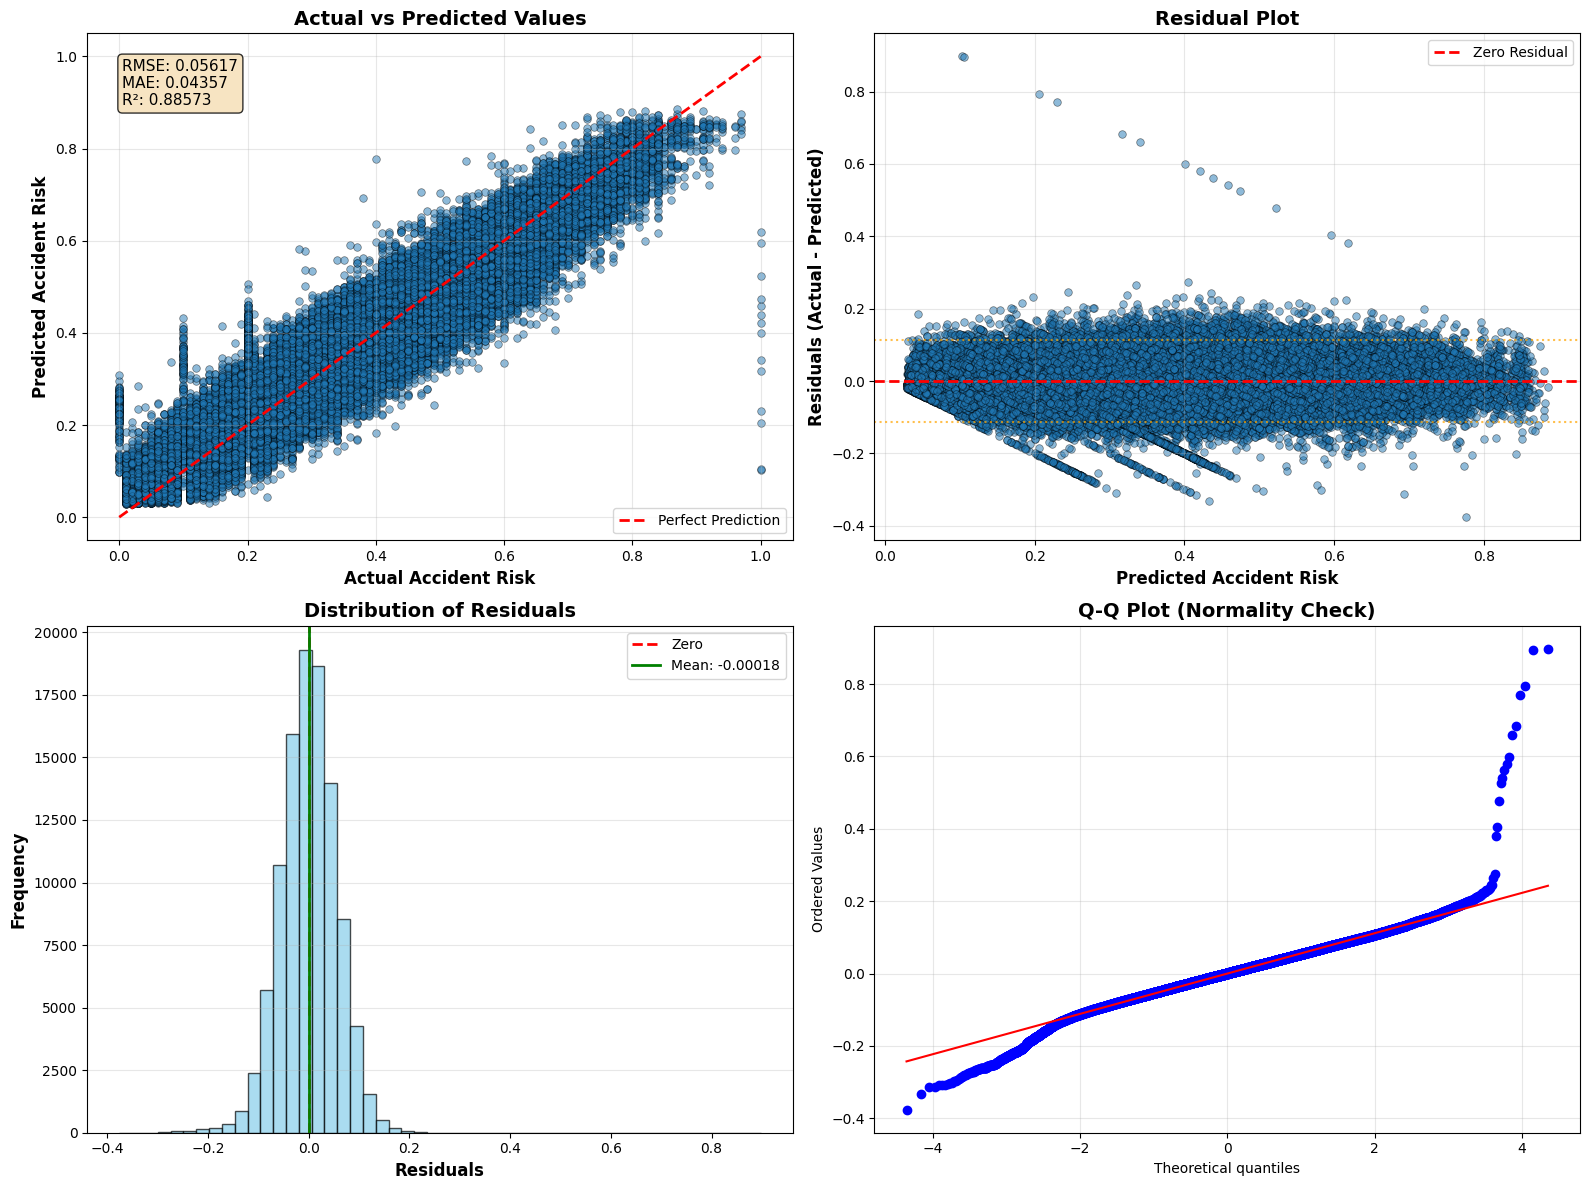

残差分析サマリー
サンプル数: 103551

【評価指標】
RMSE (Root Mean Squared Error): 0.056172
MAE  (Mean Absolute Error):     0.043571
R²   (Coefficient of Determination): 0.885729

【残差統計】
残差の平均:   -0.000177
残差の標準偏差: 0.056171
残差の最小値: -0.376402
残差の最大値: 0.897427

【外れ値検出】
±2σを超える外れ値の数: 4273 (4.13%)

2. 予測範囲別の残差分析


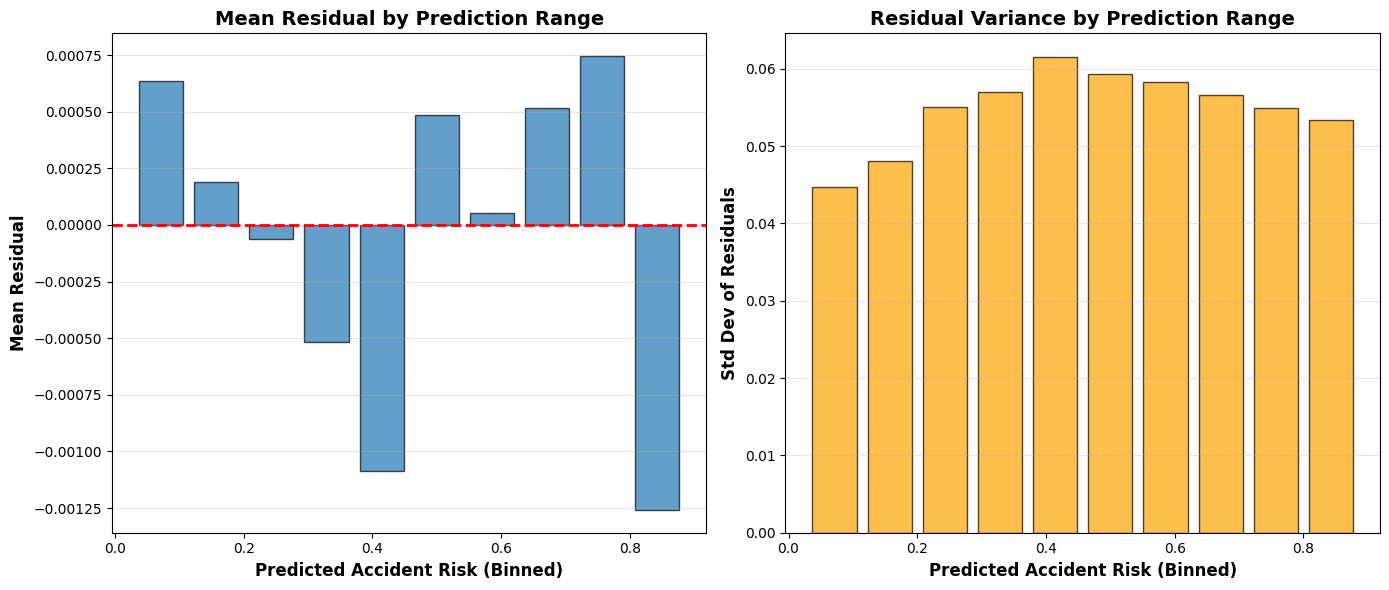


3. 誤差分布の詳細分析


/var/folders/cn/wb1xxprs41l8cbm22w4cs68w0000gn/T/ipykernel_37427/4210867147.py:203: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot([residuals], labels=['Residuals'], patch_artist=True)


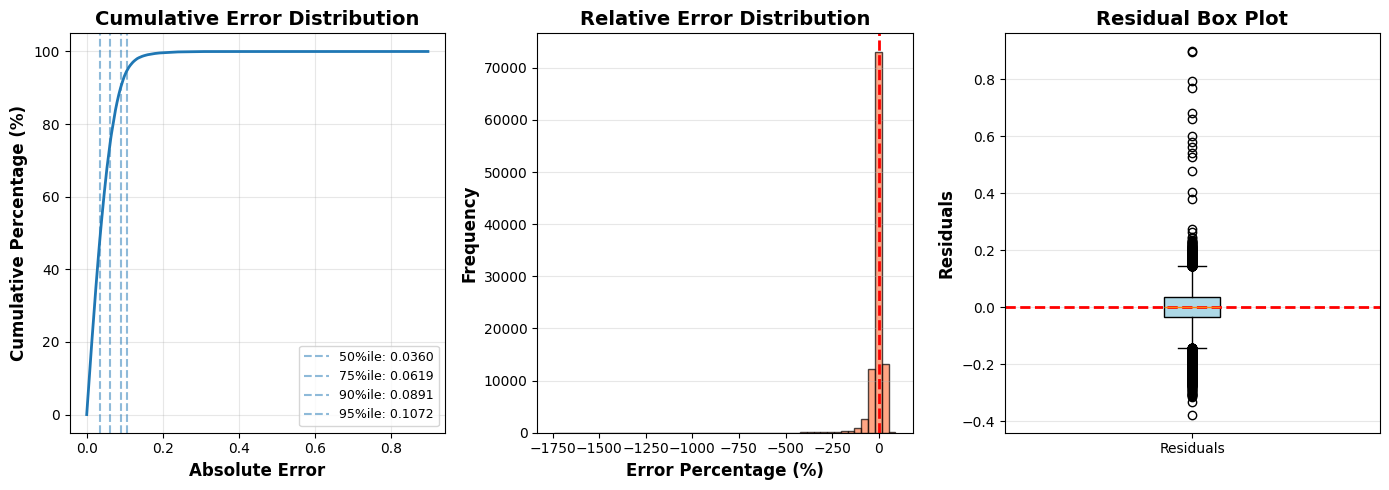


誤差パーセンタイル:
25%: 0.017004
50%: 0.036039
75%: 0.061913
90%: 0.089128
95%: 0.107247
99%: 0.156344


In [17]:
# 1. 総合分析（最も重要）
print("=" * 60)
print("1. 総合残差分析")
print("=" * 60)
residuals = plot_residual_analysis(y_test, optimized_pred)

# 2. 範囲別分析
print("\n" + "=" * 60)
print("2. 予測範囲別の残差分析")
print("=" * 60)
plot_residual_by_range(y_test, optimized_pred, n_bins=10)

# 3. 誤差分布分析
print("\n" + "=" * 60)
print("3. 誤差分布の詳細分析")
print("=" * 60)
plot_error_distribution(y_test, optimized_pred)

In [23]:
import joblib
import os

file_path = "model/lgb_model/lgb_model_4.pkl"

if os.path.exists(file_path):
    print(f"⚠️ ファイルが既にあります: {file_path}")
else:
    joblib.dump(optimized_lgb, file_path)  # ← joblib で保存！
    print(f"✅ モデルを保存しました: {file_path}")


✅ モデルを保存しました: model/lgb_model/lgb_model_4.pkl


In [19]:
import joblib

loaded_lgb = joblib.load("model/lgb_model/lgb_model_1.pkl")

# 予測
#y_pred = loaded_lgb.predict(X_test)


# 提出準備

In [20]:
# テストデータ予測
predict_y = optimized_lgb.predict(predict_X)
predict_df = pd.DataFrame(predict_y, columns=['accident_risk'])
submission = pd.concat([predict['id'], predict_df], axis=1)

display(submission.head())
print(submission.isnull().sum())

,id,accident_risk
0,517754,0.296784
1,517755,0.124478
2,517756,0.181343
3,517757,0.304791
4,517758,0.404696


id               0
accident_risk    0
dtype: int64


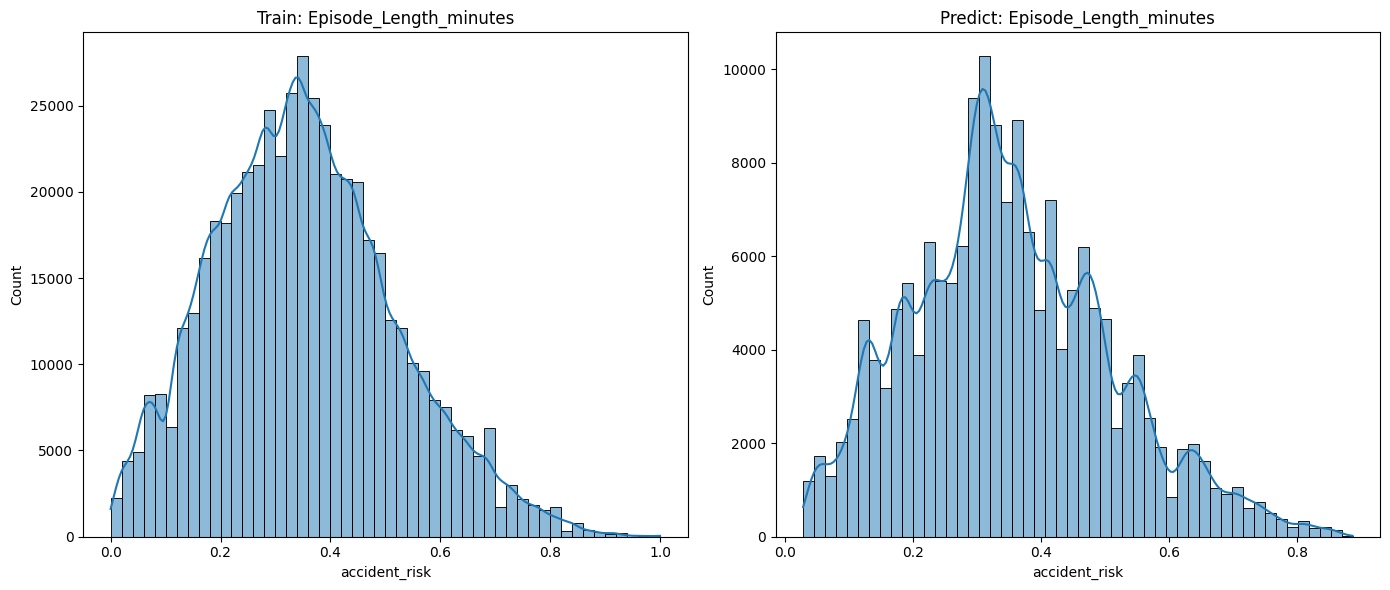

In [21]:
# サブプロットの準備（横に2つ）
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# train データのヒストグラム + KDE
sns.histplot(train['accident_risk'].dropna(), kde=True, bins=50, ax=axs[0])
axs[0].set_title('Train: Episode_Length_minutes')
#axs[0].set_xlabel('Episode_Length_minutes')

# predict データのヒストグラム + KDE
sns.histplot(submission['accident_risk'].dropna(), kde=True, bins=50, ax=axs[1])
axs[1].set_title('Predict: Episode_Length_minutes')
#axs[1].set_xlabel('Episode_Length_minutes')

# レイアウト調整して表示
plt.tight_layout()
plt.show()

In [22]:
file_path = '../submit/lgb/lgb_model_2.csv'

if os.path.exists(file_path):
     print(f"ファイルが既にあります{file_path}.")
else:
    submission.to_csv(file_path, index=False)
    print(f"ファイルを保存しました: {file_path}")

ファイルが既にあります../submit/lgb/lgb_model_2.csv.
